In [20]:
# =========================
# Environment Setup
# =========================

import os
import sys

# Ensure Homebrew binaries (mdb-export) are visible
for p in ["/opt/homebrew/bin", "/usr/local/bin"]:
    if p not in os.environ.get("PATH", ""):
        os.environ["PATH"] = p + ":" + os.environ.get("PATH", "")

# Install packages ONLY if needed (run once, then comment out)
# !{sys.executable} -m pip install tensorflow xgboost seaborn networkx

# =========================
# Imports
# =========================

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import xgboost as xgb

In [21]:
# =========================
# MDB Table Reader
# =========================

mdb_file = r'/Users/jordan/desktop/avall.mdb'

def read_mdb_table(mdb_path, table_name):
    cmd = ["mdb-export", mdb_path, table_name]
    result = subprocess.run(cmd, capture_output=True, text=True)
    return pd.read_csv(StringIO(result.stdout))


In [22]:
# =========================
# Load Core Tables
# =========================

events = read_mdb_table(mdb_file, 'events')
events_seq = read_mdb_table(mdb_file, 'Events_Sequence')
findings = read_mdb_table(mdb_file, 'Findings')
aircraft = read_mdb_table(mdb_file, 'aircraft')
events_sq_codes = read_mdb_table(mdb_file, 'ct_seqevt')

print("Data loaded.")


/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/3597929281.py:10: DtypeWarning: Columns (0: ev_id, 1: ev_site_zipcode, 2: wx_obs_tmzn, 3: metar) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))
/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/3597929281.py:10: DtypeWarning: Columns (0: ev_id, 1: Cause_Factor) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))


Data loaded.


/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/3597929281.py:10: DtypeWarning: Columns (0: ev_id, 1: dprt_pt_same_ev) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))


In [23]:
# =========================
# Shared Preprocessing
# =========================

# Sort sequence properly
events_seq = events_seq.sort_values(
    ['ev_id','Aircraft_Key','Occurrence_No']
).reset_index(drop=True)

# Drop missing severity + keep valid classes
valid_classes = ["NONE", "MINR", "SERS", "FATL"]
events_clean = events.dropna(subset=["ev_highest_injury"])
events_clean = events_clean[
    events_clean["ev_highest_injury"].isin(valid_classes)
]

print("Preprocessing complete.")


Preprocessing complete.


In [24]:
incidents = events_seq.sort_values(by = ['ev_id', 'Aircraft_Key','Occurrence_No']).reset_index(drop = True)
incidents = incidents.merge(events, on = 'ev_id', how = 'left')

incidents = incidents[incidents['ev_date'].isna()==False].reset_index(drop = True)
incidents['ev_hour'] = pd.to_datetime(incidents['ev_date'], format='%m/%d/%y %H:%M:%S').dt.hour
incidents['ev_month'] = pd.to_datetime(incidents['ev_date'], format='%m/%d/%y %H:%M:%S').dt.month

def clean_ntsb_datetime(df):
    df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')
    df['time_str'] = df['ev_time'].fillna(0).astype(int).astype(str).str.zfill(4)
    df['full_timestamp'] = pd.to_datetime(
        df['ev_date'].astype(str) + ' ' + 
        df['time_str'].str[:2] + ':' + df['time_str'].str[2:], 
        errors='coerce'
    )
    return df

incidents = clean_ntsb_datetime(incidents)
incidents['time_delta'] = incidents.groupby(['ev_id', 'Aircraft_Key'])['full_timestamp'].diff()
incidents['delta_minutes'] = incidents['time_delta'].dt.total_seconds() / 60
incidents['delta_minutes'] = incidents['delta_minutes'].fillna(0)

gaps_exist = incidents[incidents['delta_minutes'] > 0]

total_seqs = incidents['ev_id'].nunique()
zero_gap_seqs = incidents.groupby('ev_id')['delta_minutes'].sum().eq(0).sum()
print('Incidents with 0.0 total time elapsed: '+str(zero_gap_seqs))
print('Incidents total: '+str(total_seqs))

Incidents with 0.0 total time elapsed: 23950
Incidents total: 23950


/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/2310475974.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')


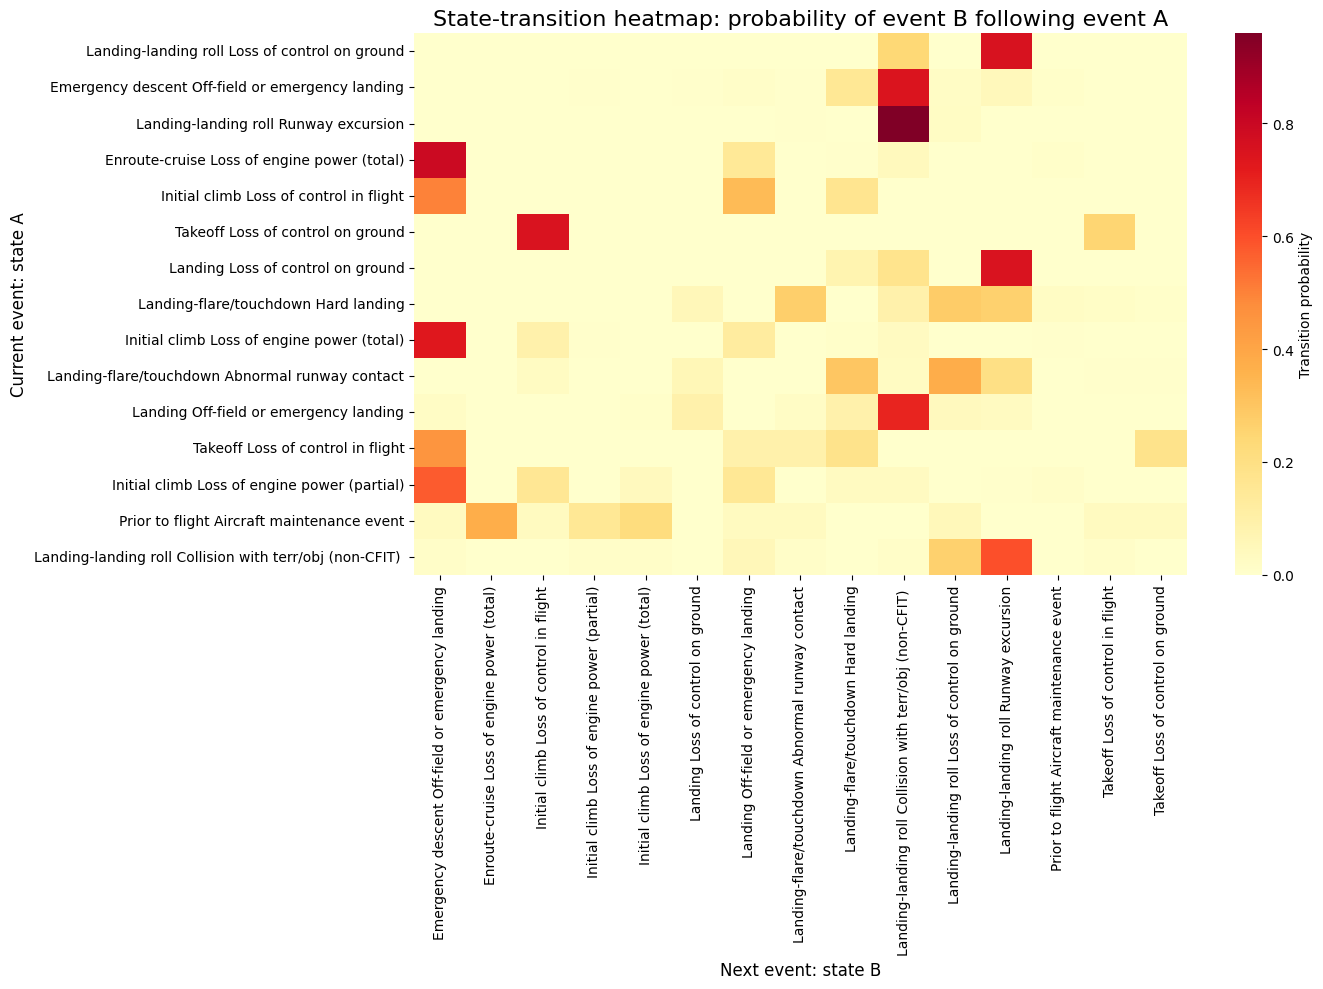

In [25]:
#EDA 1, transition matrix

incidents['next_occurrence'] = incidents.groupby(['ev_id', 'Aircraft_Key'])['Occurrence_Description'].shift(-1)

transitions = incidents[['Occurrence_Description', 'next_occurrence']].dropna()

transitions.columns = ['From_Event', 'To_Event']

import seaborn as sns
import matplotlib.pyplot as plt

matrix = pd.crosstab(transitions['From_Event'], transitions['To_Event'])

# take top 15 most frequent events
top_events = transitions['From_Event'].value_counts().nlargest(15).index
matrix_filtered = matrix.loc[top_events, matrix.columns.isin(top_events)]

# normalise matrix, turns counts into the probability of next state
matrix_norm = matrix_filtered.div(matrix_filtered.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(matrix_norm, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Transition probability'})

plt.title('State-transition heatmap: probability of event B following event A', fontsize=16)
plt.xlabel('Next event: state B', fontsize=12)
plt.ylabel('Current event: state A', fontsize=12)

plt.tight_layout()
plt.show()

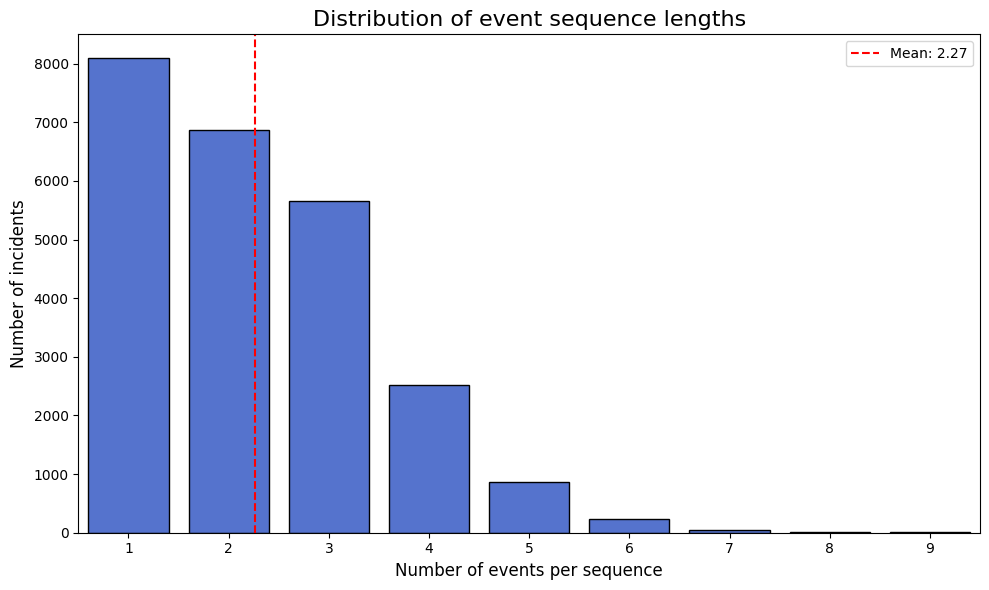

In [26]:
#EDA 2 - distribution of event sequence lengths (number of event sequence steps)

sequence_lengths = incidents.groupby(['ev_id', 'Aircraft_Key'])['Occurrence_No'].count().reset_index()
sequence_lengths.columns = ['ev_id', 'Aircraft_Key', 'seq_length']

plt.figure(figsize=(10, 6))
sns.countplot(data=sequence_lengths, x='seq_length', color='royalblue', edgecolor='black')

plt.title('Distribution of event sequence lengths', fontsize=16)
plt.xlabel('Number of events per sequence', fontsize=12)
plt.ylabel('Number of incidents', fontsize=12)

mean_val = sequence_lengths['seq_length'].mean()
plt.axvline(mean_val - 1, color='red', linestyle='--', label='Mean: '+str(round(mean_val,2)))
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/3782028973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=first_events, x='month', palette='Blues', ax=ax1, edgecolor='black')


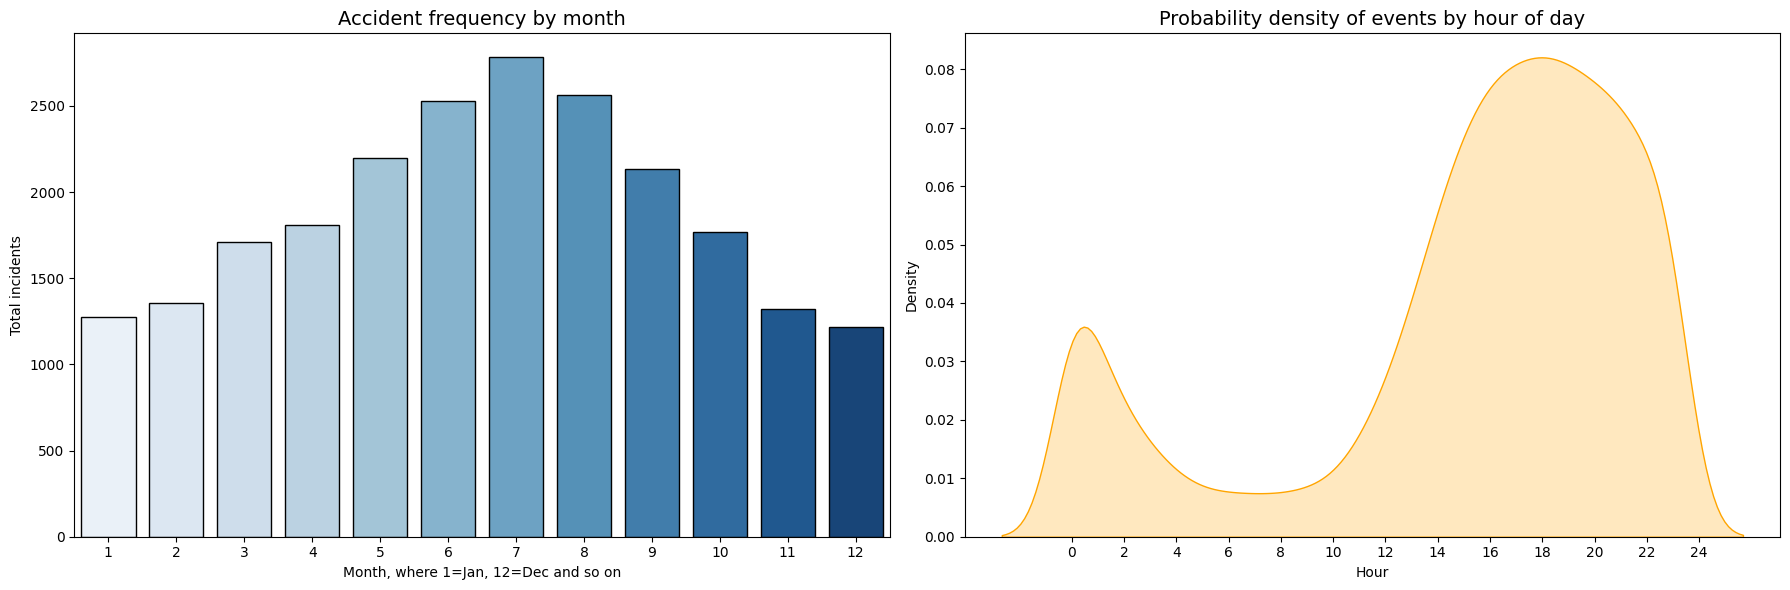

In [27]:
#EDA 3 - accident frequency by month and by hour of the day

first_events = incidents[incidents['Occurrence_No'] == 1].copy()

first_events['month'] = first_events['full_timestamp'].dt.month
first_events['hour'] = first_events['full_timestamp'].dt.hour

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# plot 1, months
sns.countplot(data=first_events, x='month', palette='Blues', ax=ax1, edgecolor='black')
ax1.set_title('Accident frequency by month', fontsize=14)
ax1.set_xlabel('Month, where 1=Jan, 12=Dec and so on')
ax1.set_ylabel('Total incidents')

# plot 2, hours 
sns.kdeplot(data=first_events, x='hour', fill=True, color='orange', ax=ax2)
ax2.set_title('Probability density of events by hour of day', fontsize=14)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Density')
ax2.set_xticks(range(0, 25, 2))

plt.tight_layout()
plt.show()

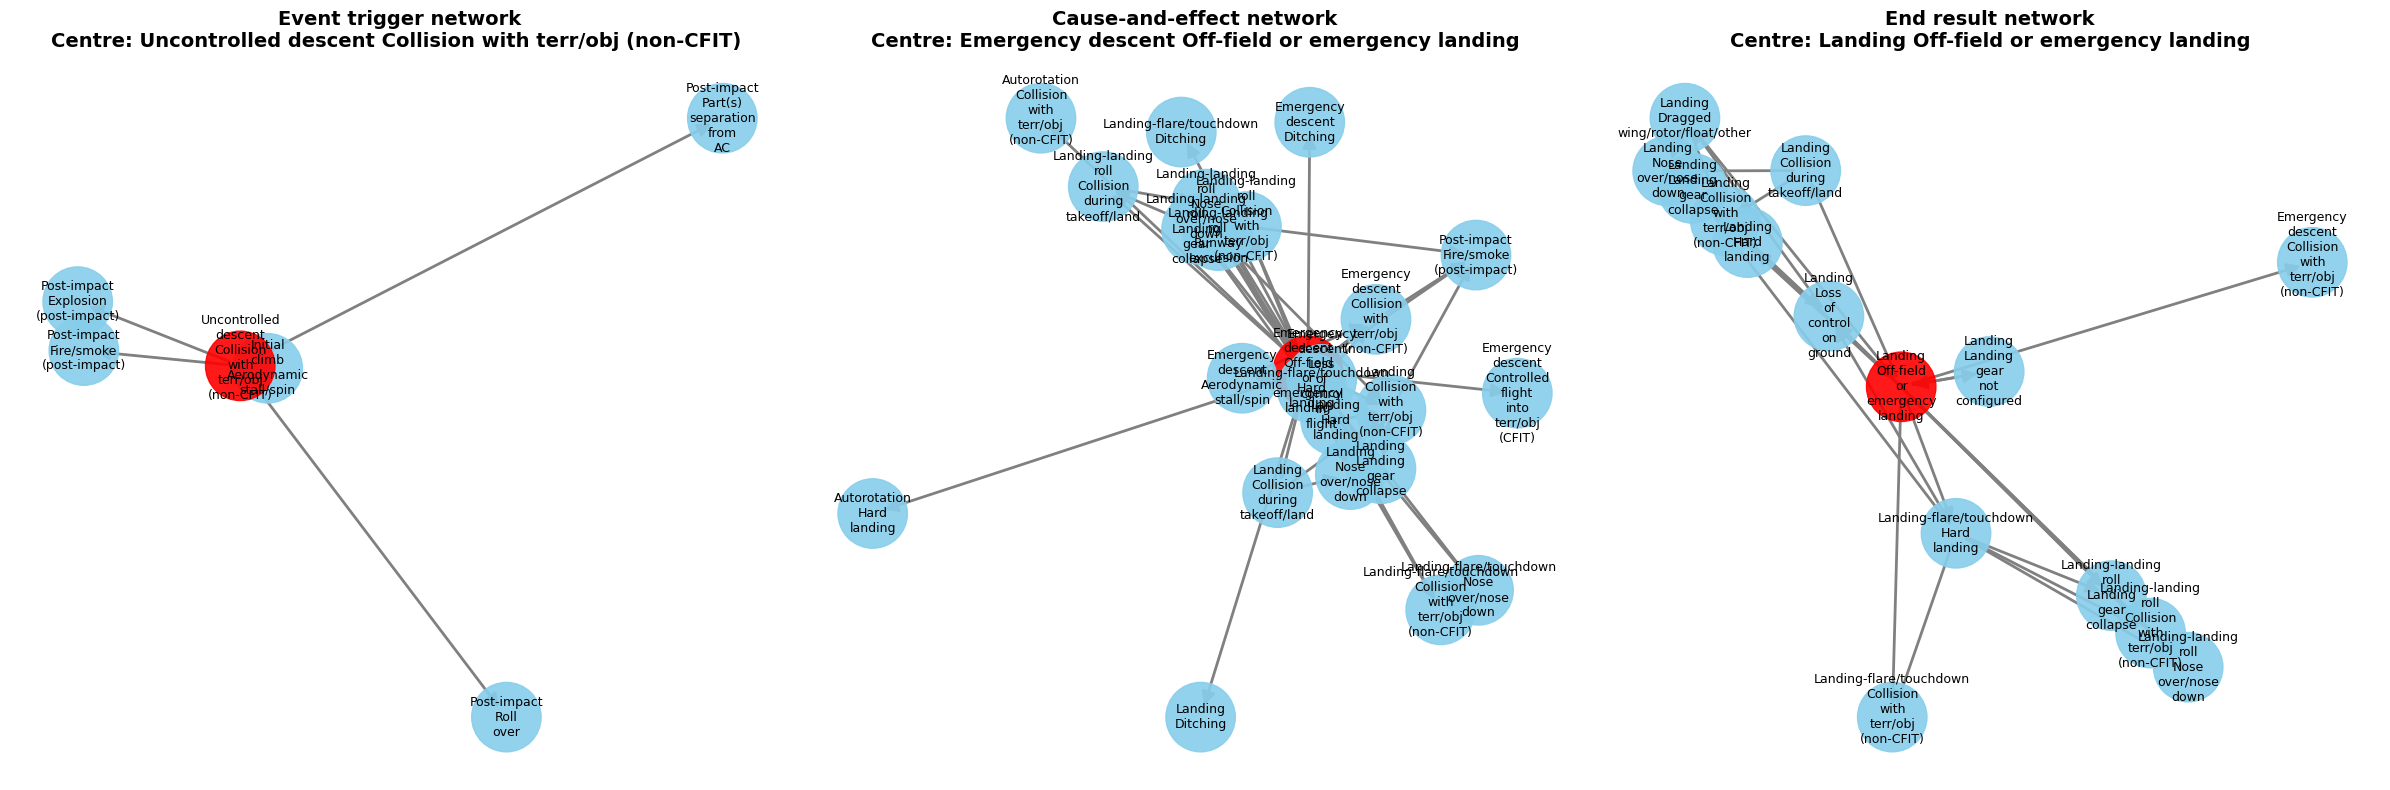

In [28]:
import networkx as nx

# EDA 4 - important community analysis 

edge_counts = transitions.groupby(['From_Event', 'To_Event']).size().reset_index(name='weight')
significant_edges = edge_counts[edge_counts['weight'] > 5]

G = nx.from_pandas_edgelist(significant_edges, 
                            source='From_Event', 
                            target='To_Event', 
                            edge_attr='weight', 
                            create_using=nx.DiGraph())


# identify most important nodes to use as centres in our graph
centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# get partitions
centers = [top_nodes[0][0], top_nodes[1][0], top_nodes[2][0]]
titles = ["Event trigger network", "Cause-and-effect network", "End result network"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i, center_node in enumerate(centers):
    # gets centre node and immediate neighbours
    ego = nx.ego_graph(G, center_node, radius=1)
    
    pos = nx.spring_layout(ego, k=0.8, seed=42)
    ax = axes[i]

    node_colors = ['red' if n == center_node else 'skyblue' for n in ego.nodes()]
    
    nx.draw_networkx_nodes(ego, pos, node_size=2500, node_color=node_colors, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(ego, pos, width=2, edge_color='gray', arrowsize=20, ax=ax)
    
    labels = {n: n.replace(' ', '\n') for n in ego.nodes()}
    nx.draw_networkx_labels(ego, pos, labels=labels, font_size=9, ax=ax)
    
    ax.set_title(f"{titles[i]}\nCentre: {center_node}", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_49935/3623976338.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(make_counts['Make'], rotation=45, ha='right')


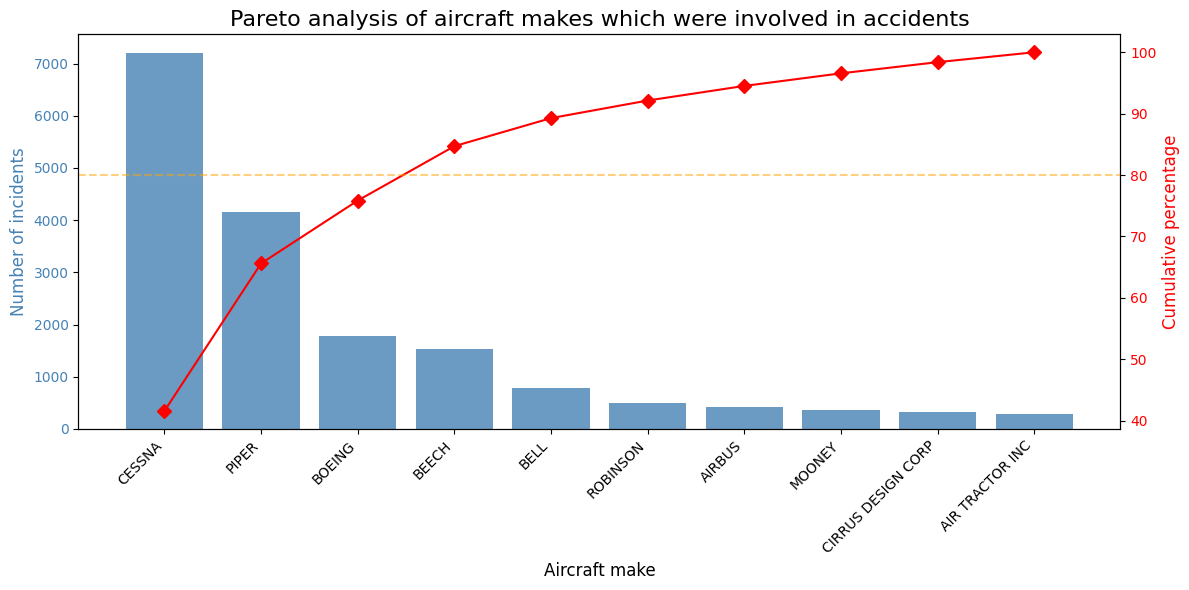

In [29]:
#EDA 5 - Pareto analysis of aircraft make in accidents 
# note: Pareto analysis tries to see the 80/20 rule in practice - i.e. are 20% of planes, say from one brand, causing 80% of accidents?

aircraft['acft_make_clean'] = aircraft['acft_make'].str.upper().str.strip()
make_counts = aircraft['acft_make_clean'].value_counts().head(10).reset_index()
make_counts.columns = ['Make', 'Count']

make_counts['cum_percentage'] = make_counts['Count'].cumsum() / make_counts['Count'].sum() * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(make_counts['Make'], make_counts['Count'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Aircraft make', fontsize=12)
ax1.set_ylabel('Number of incidents', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(make_counts['Make'], make_counts['cum_percentage'], color='red', marker='D', ms=7, label='Cumulative %')
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5) #threshold
ax2.set_ylabel('Cumulative percentage', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Pareto analysis of aircraft makes which were involved in accidents', fontsize=16)
ax1.set_xticklabels(make_counts['Make'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

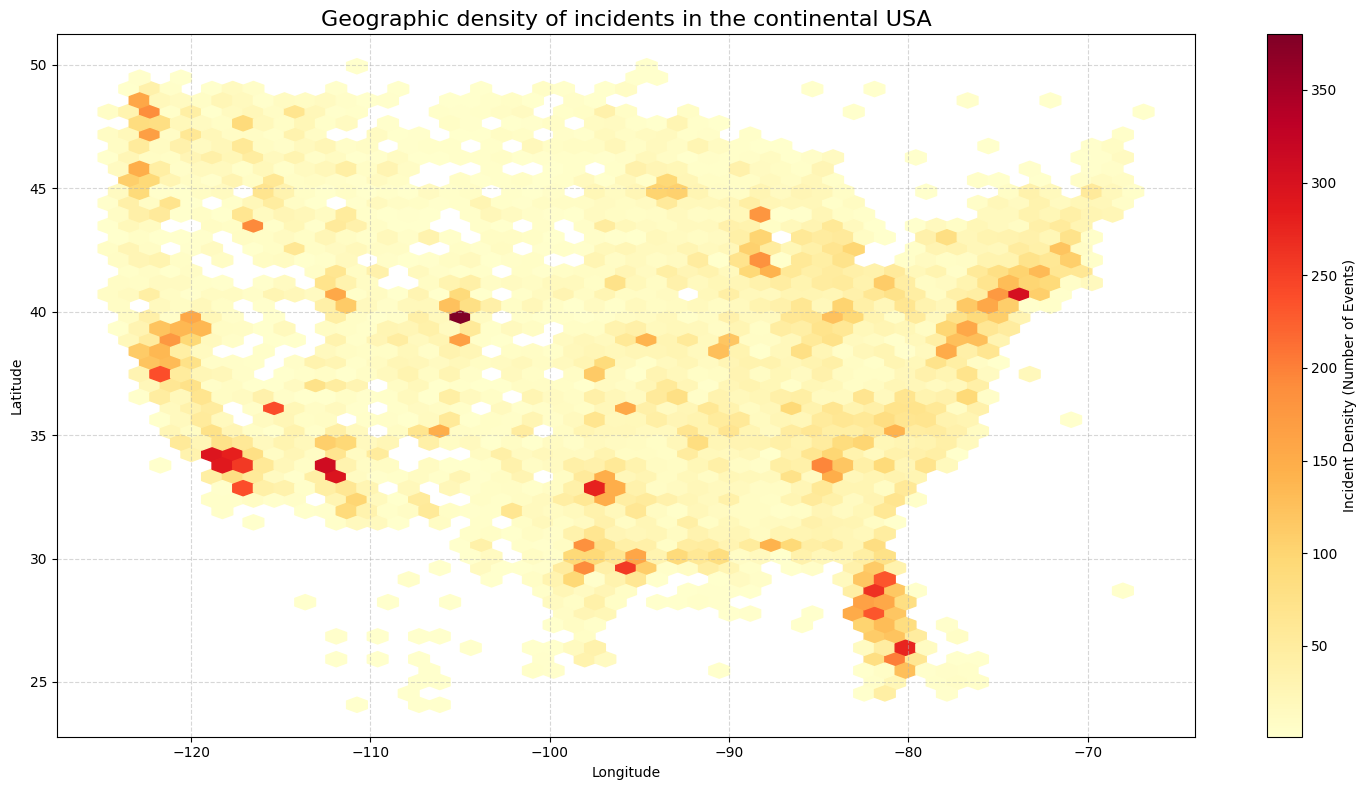

In [30]:
#EDA 6 - geographic distribution of accidents, continental USA

geo_data = incidents.dropna(subset=['dec_latitude', 'dec_longitude'])
geo_data = geo_data[(geo_data['dec_latitude'] > 24) & (geo_data['dec_latitude'] < 50) & 
                    (geo_data['dec_longitude'] > -125) & (geo_data['dec_longitude'] < -66)]

plt.figure(figsize=(15, 8))

hb = plt.hexbin(geo_data['dec_longitude'], geo_data['dec_latitude'], 
                gridsize=50, cmap='YlOrRd', mincnt=1)

cb = plt.colorbar(hb, ax=plt.gca())
cb.set_label('Incident Density (Number of Events)')

plt.title('Geographic density of incidents in the continental USA', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

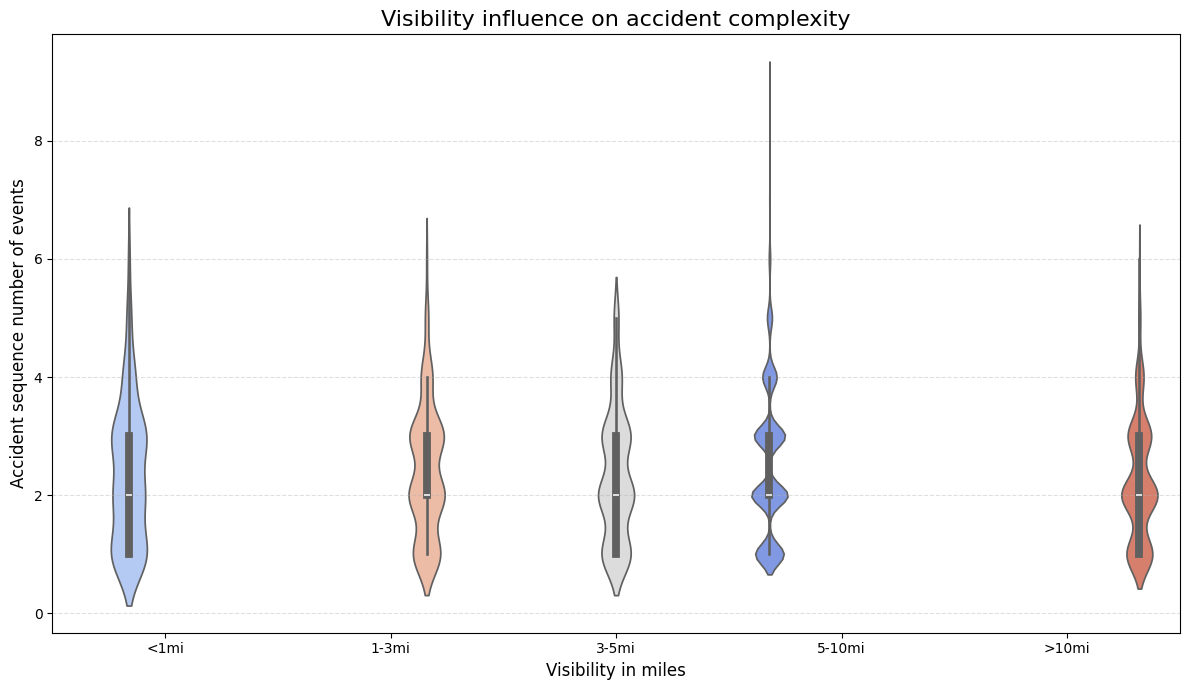

In [31]:
#EDA 7 - visibility's influence on accident complexity

weather_cols = ['vis_sm', 'wind_vel_kts', 'sky_ceil_ht']
for col in weather_cols:
    incidents[col] = pd.to_numeric(incidents[col], errors='coerce')

weather_impact = pd.merge(incidents[incidents['Occurrence_No'] == 1], 
                         sequence_lengths[['ev_id', 'seq_length']], 
                         on='ev_id')

plt.figure(figsize=(12, 7))

weather_impact['vis_category'] = pd.cut(weather_impact['vis_sm'], 
                                       bins=[0, 1, 3, 5, 10, 50], 
                                       labels=['<1mi', '1-3mi', '3-5mi', '5-10mi', '>10mi'])

sns.violinplot(data=weather_impact.dropna(subset=['vis_category']), 
               x='vis_category', y='seq_length', 
               hue='vis_category', palette='coolwarm', legend=False)

plt.title('Visibility influence on accident complexity', fontsize=16)
plt.xlabel('Visibility in miles', fontsize=12)
plt.ylabel('Accident sequence number of events', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

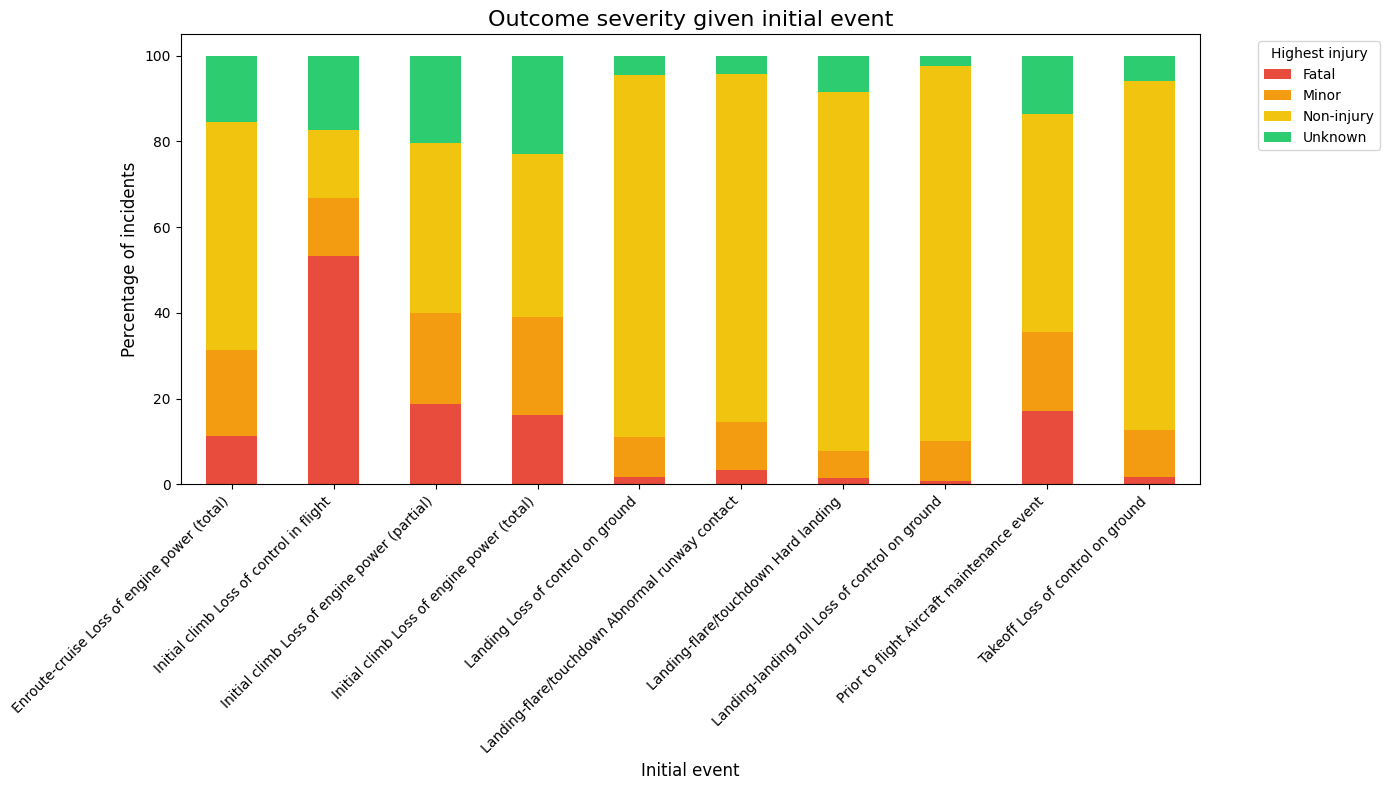

In [32]:
#EDA 8 - severity, outcome analysis

#simplify injury categories, 'FATL', 'NONE', 'SVR', 'MINR' are grouped
severity_map = {
    'FATL': 'Fatal',
    'SVR': 'Serious',
    'MINR': 'Minor',
    'NONE': 'Non-injury'
}
incidents['severity'] = incidents['ev_highest_injury'].map(severity_map).fillna('Unknown')

starting_events = incidents[incidents['Occurrence_No'] == 1].copy()

# 3. filter for top 10 events
top_starts = starting_events['Occurrence_Description'].value_counts().nlargest(10).index
plot_data = starting_events[starting_events['Occurrence_Description'].isin(top_starts)]

plt.figure(figsize=(14, 8))
pivot_data = pd.crosstab(plot_data['Occurrence_Description'], plot_data['severity'], normalize='index') * 100

pivot_data.plot(kind='bar', stacked=True, color=['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71'], ax=plt.gca())

plt.title('Outcome severity given initial event', fontsize=16)
plt.ylabel('Percentage of incidents', fontsize=12)
plt.xlabel('Initial event', fontsize=12)
plt.legend(title='Highest injury', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [33]:
# =========================
# Model 1: Early-Sequence LSTM
# =========================

# Aggregate sequences
seq_grouped = (
    events_seq
    .groupby(["ev_id", "Aircraft_Key"])["Occurrence_Code"]
    .apply(list)
    .reset_index()
)

# Keep first two events
seq_grouped["first_two"] = seq_grouped["Occurrence_Code"].apply(lambda x: x[:2])

# Merge severity
incident_df = seq_grouped.merge(
    events_clean[["ev_id", "ev_highest_injury"]],
    on="ev_id",
    how="inner"
)

# Encode sequences
occ_le = LabelEncoder()
all_codes = np.concatenate(incident_df["first_two"].values)
occ_le.fit(all_codes)

incident_df["seq_encoded"] = incident_df["first_two"].apply(
    lambda x: occ_le.transform(x)
)

X = pad_sequences(incident_df["seq_encoded"], maxlen=2, padding="post")

# Encode severity
sev_le = LabelEncoder()
y = sev_le.fit_transform(incident_df["ev_highest_injury"])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(occ_le.classes_)+1, 64, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(sev_le.classes_), activation="softmax")
])

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Train
history = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weights_dict
)

# Evaluate
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)

print(classification_report(
    y_test,
    y_pred_lstm,
    target_names=sev_le.classes_
))


Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5020 - loss: 1.2228 - val_accuracy: 0.5557 - val_loss: 1.0967
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5573 - loss: 1.1132 - val_accuracy: 0.5477 - val_loss: 1.0807
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5751 - loss: 1.0732 - val_accuracy: 0.5503 - val_loss: 1.0804
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5825 - loss: 1.0470 - val_accuracy: 0.5253 - val_loss: 1.0972
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5848 - loss: 1.0249 - val_accuracy: 0.5189 - val_loss: 1.1144
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5855 - loss: 1.0045 - val_accuracy: 0.5242 - val_loss: 1.1149
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5866 - loss: 0.9914 - val_accuracy: 0.5392 - val_loss: 1.0974
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5933 - loss: 0.9767 - val_accuracy: 0.

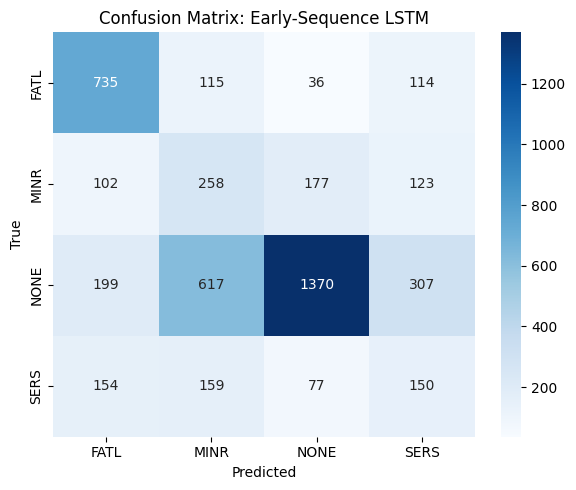

In [34]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=sev_le.classes_,
            yticklabels=sev_le.classes_)

plt.title("Confusion Matrix: Early-Sequence LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm.png", dpi=300)
plt.show()


In [35]:
# =========================
# Model 2: XGBoost
# =========================

# Extract first two events
first_two = events_seq.groupby(
    ['ev_id','Aircraft_Key']
).head(2).copy()

first_two['event_order'] = first_two.groupby(
    ['ev_id','Aircraft_Key']
).cumcount()

wide = first_two.pivot_table(
    index=['ev_id','Aircraft_Key'],
    columns='event_order',
    values='Occurrence_Code',
    aggfunc='first'
).reset_index()

wide.columns = ['ev_id','Aircraft_Key','event_1','event_2']

# Merge contextual variables
features_df = wide.merge(
    events_clean[['ev_id',
                  'ev_highest_injury',
                  'ev_month',
                  'light_cond',
                  'wx_cond_basic',
                  'wind_vel_kts',
                  'vis_sm',
                  'mid_air',
                  'on_ground_collision']],
    on='ev_id',
    how='inner'
)

features_df = features_df.fillna(-1)
features_df['ev_highest_injury'] = features_df['ev_highest_injury'].astype(str)

# Encode target
sev_le_xgb = LabelEncoder()
features_df['severity_encoded'] = sev_le_xgb.fit_transform(
    features_df['ev_highest_injury']
)

# Feature matrix
X = features_df.drop(columns=['ev_id','Aircraft_Key',
                              'ev_highest_injury',
                              'severity_encoded'])
X = pd.get_dummies(X, drop_first=False)
y = features_df['severity_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1021
)

model_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(sev_le_xgb.classes_),
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1021
)

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=sev_le_xgb.classes_
))


              precision    recall  f1-score   support

        FATL       0.63      0.69      0.66      1000
        MINR       0.35      0.02      0.03       660
        NONE       0.65      0.92      0.76      2493
        SERS       0.72      0.07      0.13       540

    accuracy                           0.64      4693
   macro avg       0.59      0.42      0.40      4693
weighted avg       0.61      0.64      0.56      4693



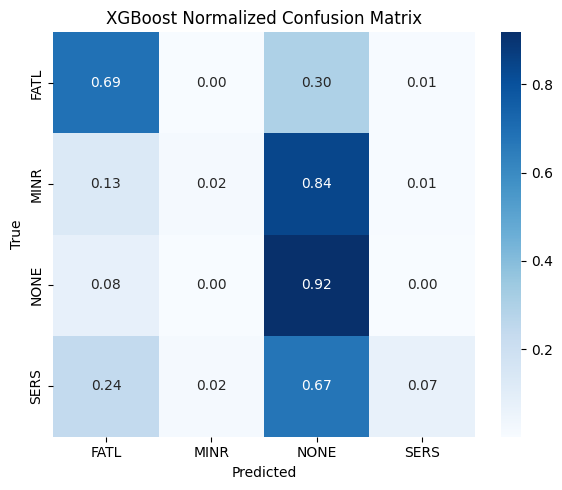

In [36]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=sev_le_xgb.classes_,
            yticklabels=sev_le_xgb.classes_)

plt.title("XGBoost Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
